In [9]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
from helper import train_VAE 
from VAE_model import VAE
import json
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200

In [10]:
X_train = pd.read_csv('../../datasets/Admission/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Admission/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Admission/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Admission/y_test.csv',index_col=0) 
X_train_with_confounder=X_train.drop(columns=['CGPA'])
X_test_with_confounder=X_test.drop(columns=['CGPA'])
print(X_train.shape)
print(X_train_with_confounder)
print(X_test.shape)
print(X_test_with_confounder.shape)
print(X_train.columns)
print(X_train_with_confounder.columns)
X_train_with_confounder

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_confounder)
X_test_scaled = scaler.transform(X_test_with_confounder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

(400, 7)
     GRE Score  TOEFL Score  University Rating  SOP  LOR   Research
60         309          100                  2  3.0   3.0         0
298        330          114                  3  4.5   4.5         1
228        318          112                  3  4.0   3.5         0
141        332          118                  2  4.5   3.5         1
3          322          110                  3  3.5   2.5         1
..         ...          ...                ...  ...   ...       ...
381        319          105                  3  3.0   3.5         1
37         300          105                  1  1.0   2.0         0
153        324          105                  3  3.0   4.0         0
396        325          107                  3  3.0   3.5         1
101        312          105                  2  2.5   3.0         0

[400 rows x 6 columns]
(100, 7)
(100, 6)
Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research'],
      dtype='object')
Index(['GRE 

device(type='cuda')

In [11]:
config={"config": {"x_dim": 6, "z_dim": 3, "zz_dim": 1, "encoder_z_layers": [10, 10, 10], "encoder_zz_layers": [10, 10], "decoder_layers": [10, 10, 10, 6], "fc_z_to_y_layers": [12, 12, 1]}, "beta": {"b1": 10000, "b2": 1, "b3": 1, "b4": 10000, "b5": 1}, "lr": 0.001, "batch_size": 16, "num_epochs": 200}

In [12]:
config_params = config['config']
beta = config['beta']
lr = config['lr']
batch_size = config['batch_size']
num_epochs = config['num_epochs']

x_dim = config_params['x_dim']
z_dim = config_params['z_dim']
zz_dim = config_params['zz_dim']
encoder_z_layers = config_params['encoder_z_layers']
encoder_zz_layers = config_params['encoder_zz_layers']
decoder_layers = config_params['decoder_layers']
fc_z_to_y_layers = config_params['fc_z_to_y_layers']
b1 = beta['b1']
b2 = beta['b2']
b3 = beta['b3']
b4 = beta['b4']
b5 = beta['b5']
model=VAE(x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, decoder_layers, fc_z_to_y_layers,z_and_zz_to_y=False)

In [13]:
model = torch.load("./Models/Admission_No_freeze_zz_to_y_R2_0_7003722554344827_model.zip")
model.eval()

VAE(
  (encoder_z_seq): Sequential(
    (0): Linear(in_features=6, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
  )
  (fc21): Linear(in_features=10, out_features=3, bias=True)
  (fc22): Linear(in_features=10, out_features=3, bias=True)
  (encoder_zz_seq): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (fcz21): Linear(in_features=10, out_features=1, bias=True)
  (fcz22): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias

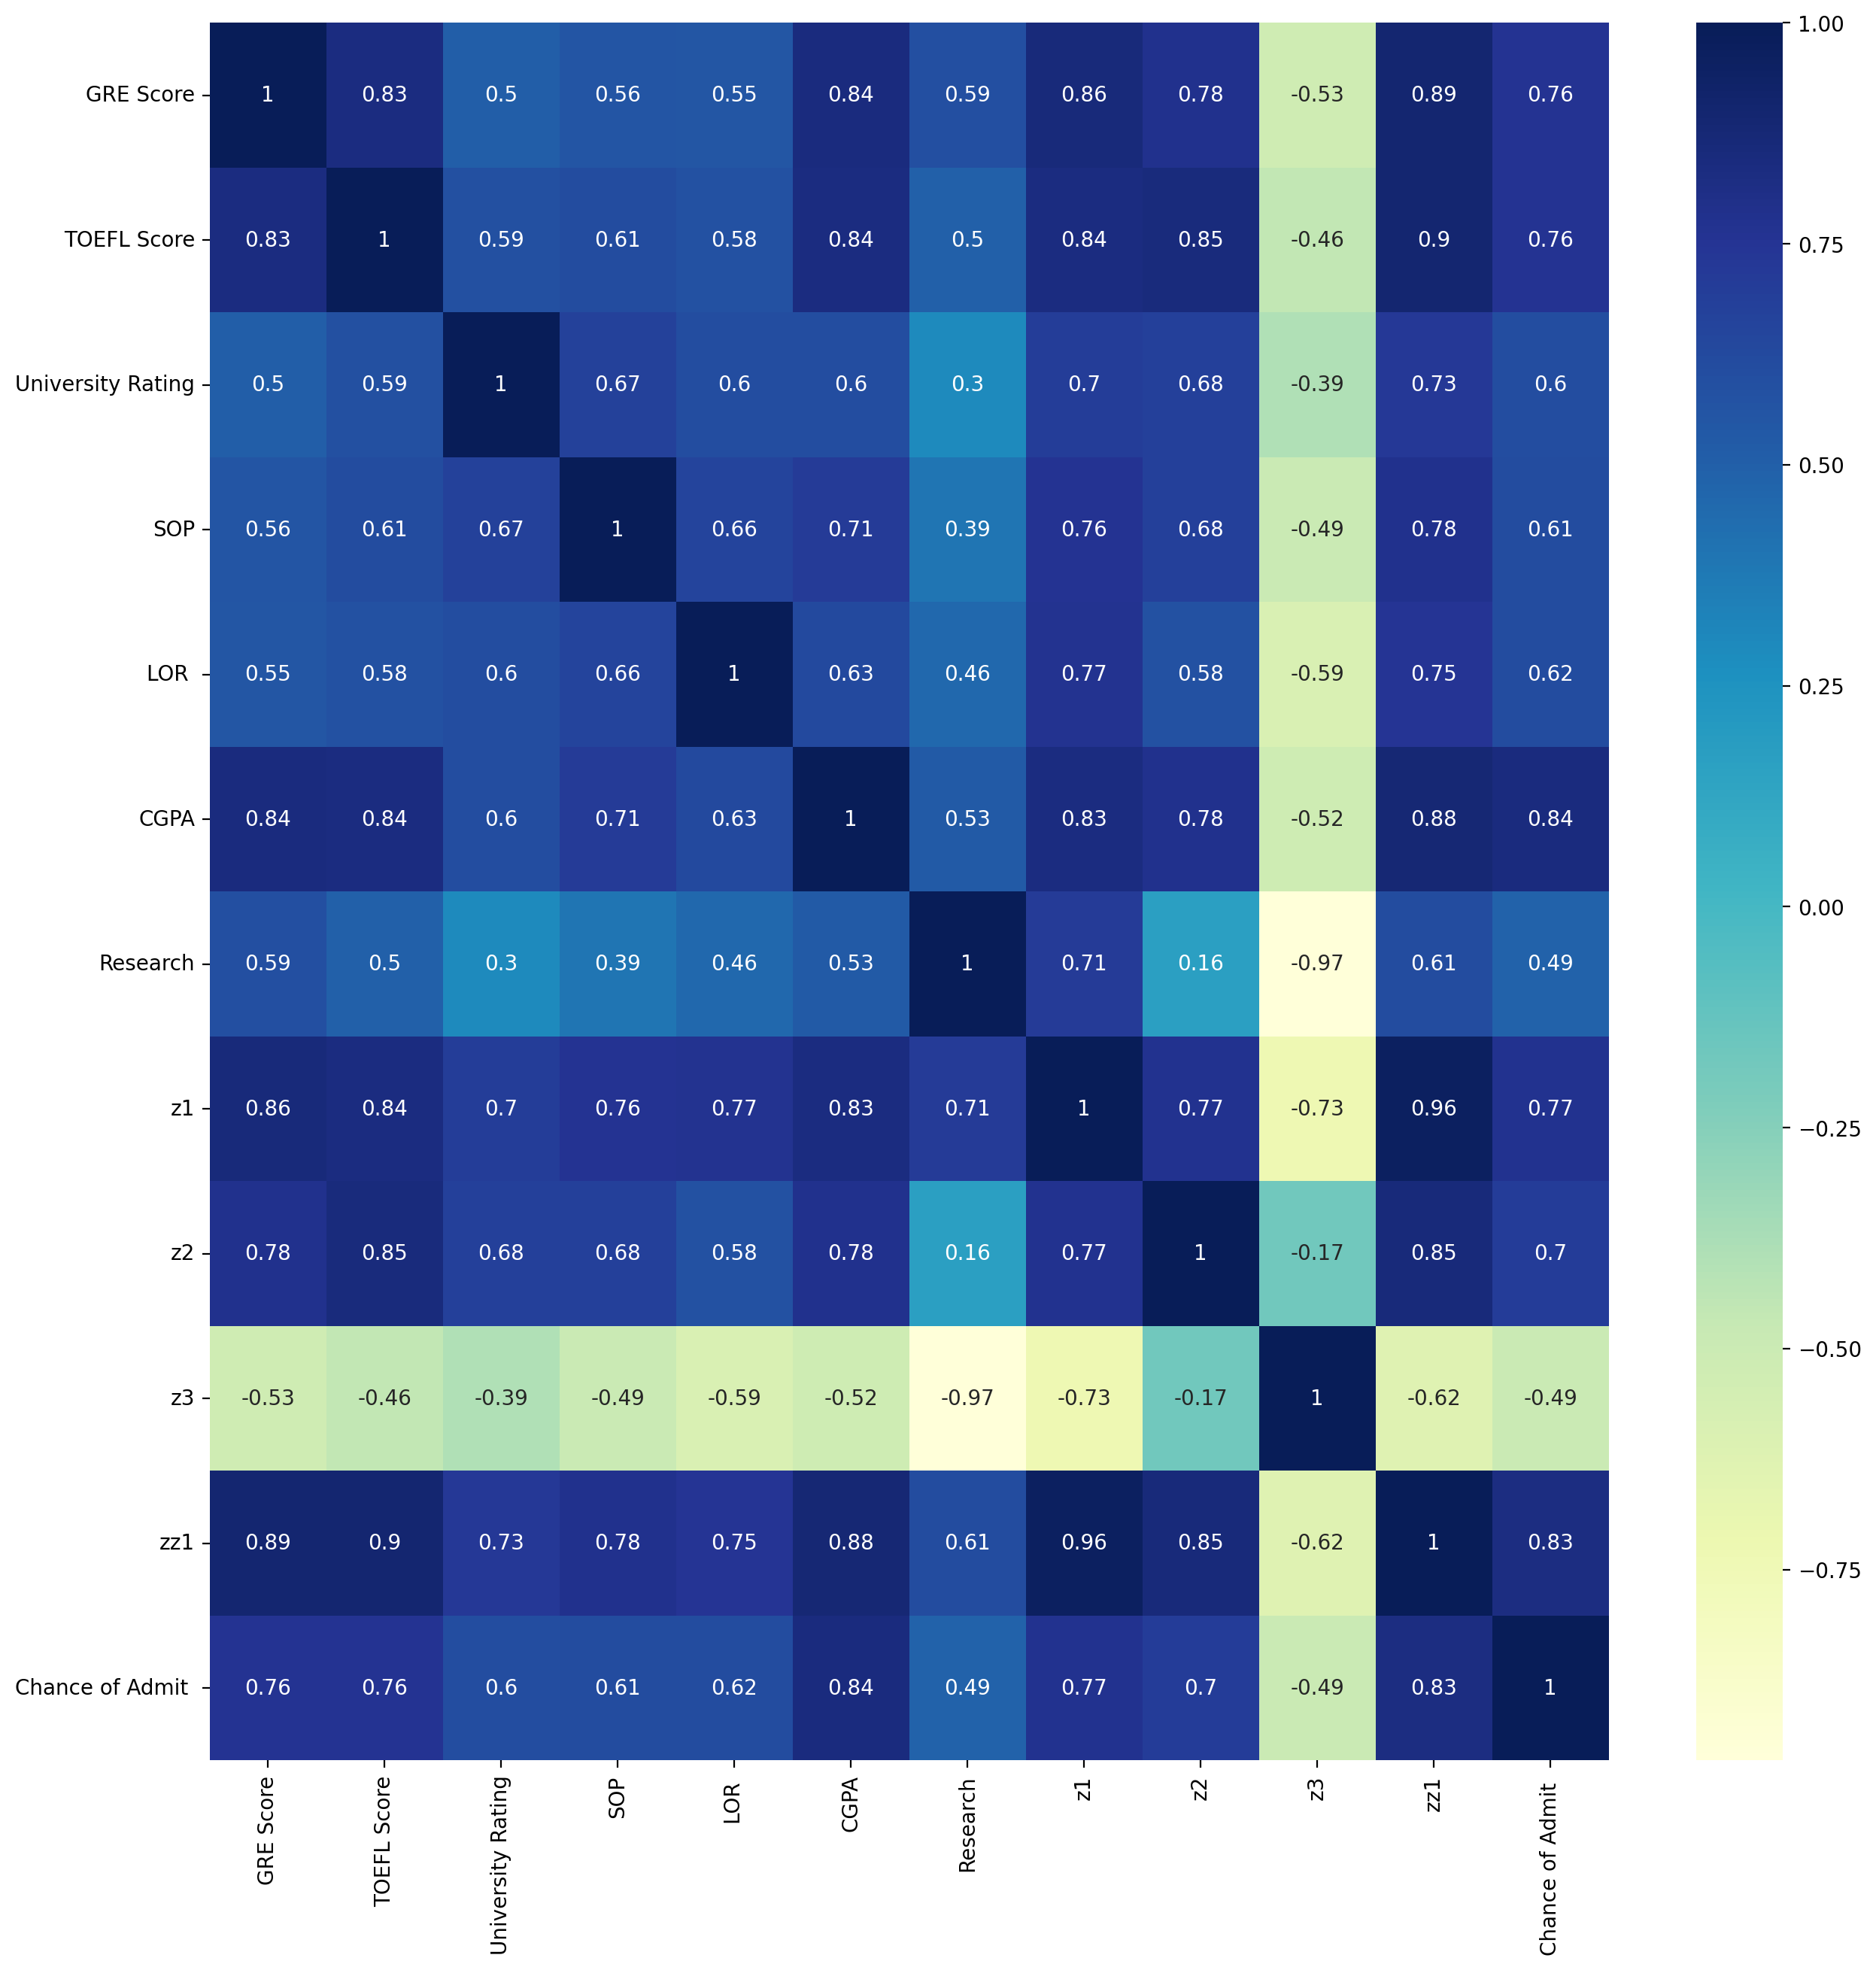

In [14]:
recon_x_subset, mu_z, log_z, mu_zz, log_zz,_ = model(torch.from_numpy(X_test_scaled).float().to(device))
# Reparameterize to get the estimated z values
z_est_subset = model.reparameterize(mu_z, log_z,1)
zz_est_subset = model.reparameterize(mu_zz, log_zz,1)


z_columns = [f'z{i+1}' for i in range(z_dim)]
zz_columns = [f'zz{i+1}' for i in range(zz_dim)]

# Convert your tensor to a dataframe
zz_est_df = pd.DataFrame(zz_est_subset.cpu().detach().numpy(), columns=zz_columns)
z_est_df = pd.DataFrame(z_est_subset.cpu().detach().numpy(), columns=z_columns)
# Reset the index of both dataframes
X_test_reset = pd.DataFrame(X_test).reset_index(drop=True)
z_est_df_reset = z_est_df.reset_index(drop=True)
zz_est_df = zz_est_df.reset_index(drop=True)
y_test_reset=  pd.DataFrame(y_test).reset_index(drop=True)


# Concatenate the dataframes
df = pd.concat([X_test_reset, z_est_df_reset,zz_est_df,y_test_reset], axis=1)

plt.figure(figsize=(15, 15))
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap
sns.heatmap(corr, cmap="YlGnBu",annot=True)
# Save the figure
#pic_name_heat = create_picture_name(config, "heatmap")
#print(pic_name_heat)
#plt.savefig(os.path.join(path, pic_name_heat))
plt.show()

In [15]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import random

def plot_prediction_vs_truth(model, X_s, X, y, title="Model Predictions vs Truth", num_points=300):
    device = next(model.parameters()).device

    fig, ax = plt.subplots()

    # Fetch CGPA values directly from DataFrame X
    cgpa_values = X.loc[:, 'CGPA'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')  # Using 'coolwarm' colormap. You can choose any appropriate colormap.

    with torch.no_grad():
        model = model.eval()
        _,_,_,_,_,predictions = model(torch.tensor(X_s, dtype=torch.float, device=device))
        predictions=predictions.cpu().numpy()

    # Ensure all arrays have the same length before looping
    assert len(y) == len(X_s) == len(normalized_cgpa), "Input arrays must have the same length"
    
    indices = range(len(X_s))
    
    # Sample num_points indices
    if num_points and num_points < len(indices):
        indices = random.sample(indices, num_points)
    
    for i in indices:
        color = cmap(normalized_cgpa[i])
        plt.scatter(y.iloc[i], predictions[i], color=color, alpha=0.7)

    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='CGPA')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])

    plt.show()



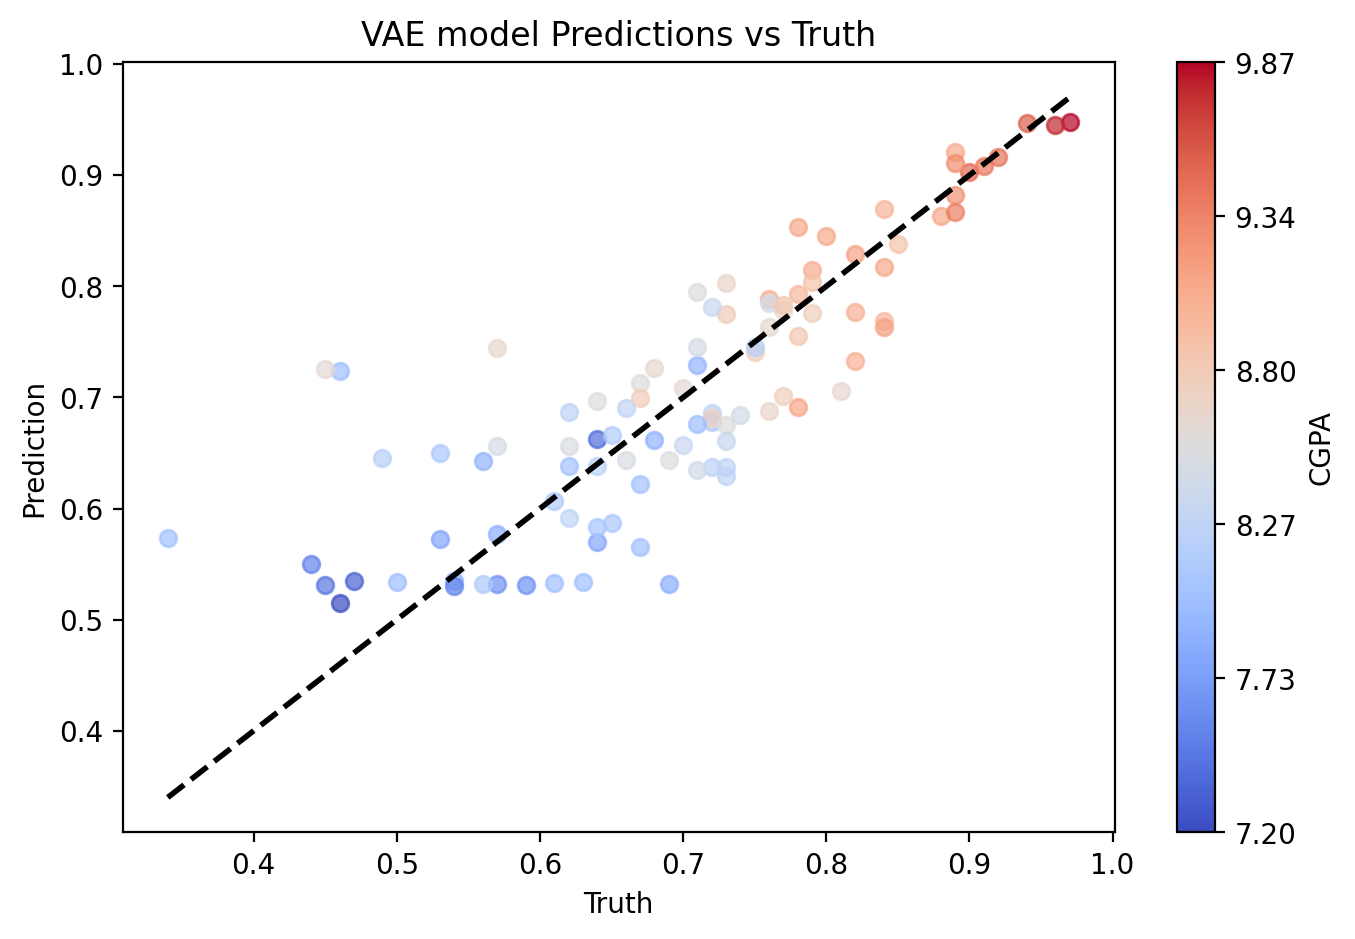

In [16]:
plot_prediction_vs_truth(model,X_test_scaled,X_test,y_test,title="VAE model Predictions vs Truth")

In [17]:
import torch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def ice_plot(model, X_s, X, y, feature_index, feature, num_points=None,off=0):
    device = next(model.parameters()).device
    
    fig, ax = plt.subplots()

    # Extract the unique feature values from the unscaled data
    feature_values = pd.unique(X.iloc[:, feature_index+off].sort_values())
    feature_values_s = np.unique(np.sort(X_s[:, feature_index]))
    
    # Normalize the CGPA values for coloring
    cgpa_values = X.loc[:, 'CGPA'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values.iloc[idx]
        feature_values_s = feature_values_s[idx]

    
    
    XXX = X_s.copy()
    predictions_all = []

    # Loop through instances in the test set
    for instance,i in zip(XXX, range(len(X_s))):
        # Create an array to store predictions for this instance
        predictions = []
        _,_,_,_,_,original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device))
        original_prediction = original_prediction.item()
        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val

            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                _,_,_,_,_,prediction = model(instance_tensor)
                prediction=prediction.item()
            predictions.append(prediction)

        predictions_all.append(predictions)

        # Plot the ICE curve for this instance in the color corresponding to CGPA value with transparency
        plt.plot(feature_values, predictions, color=cmap(normalized_cgpa[i]), alpha=0.5)
        
        # Plot the marker for the original value
        original_val = X.iloc[i, feature_index+off]
        plt.scatter(original_val, original_prediction, marker='o', color=cmap(normalized_cgpa[i]), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)

    # Plot the mean ICE curve in black and thicker
    plt.plot(feature_values, mean_predictions, color='black', linewidth=2)

    # Label the plot
    plt.xlabel(feature)
    plt.ylabel('Predictions')
    plt.title('ICE plot for {}'.format(feature))
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='CGPA')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])


    # Show the plot
    plt.show()


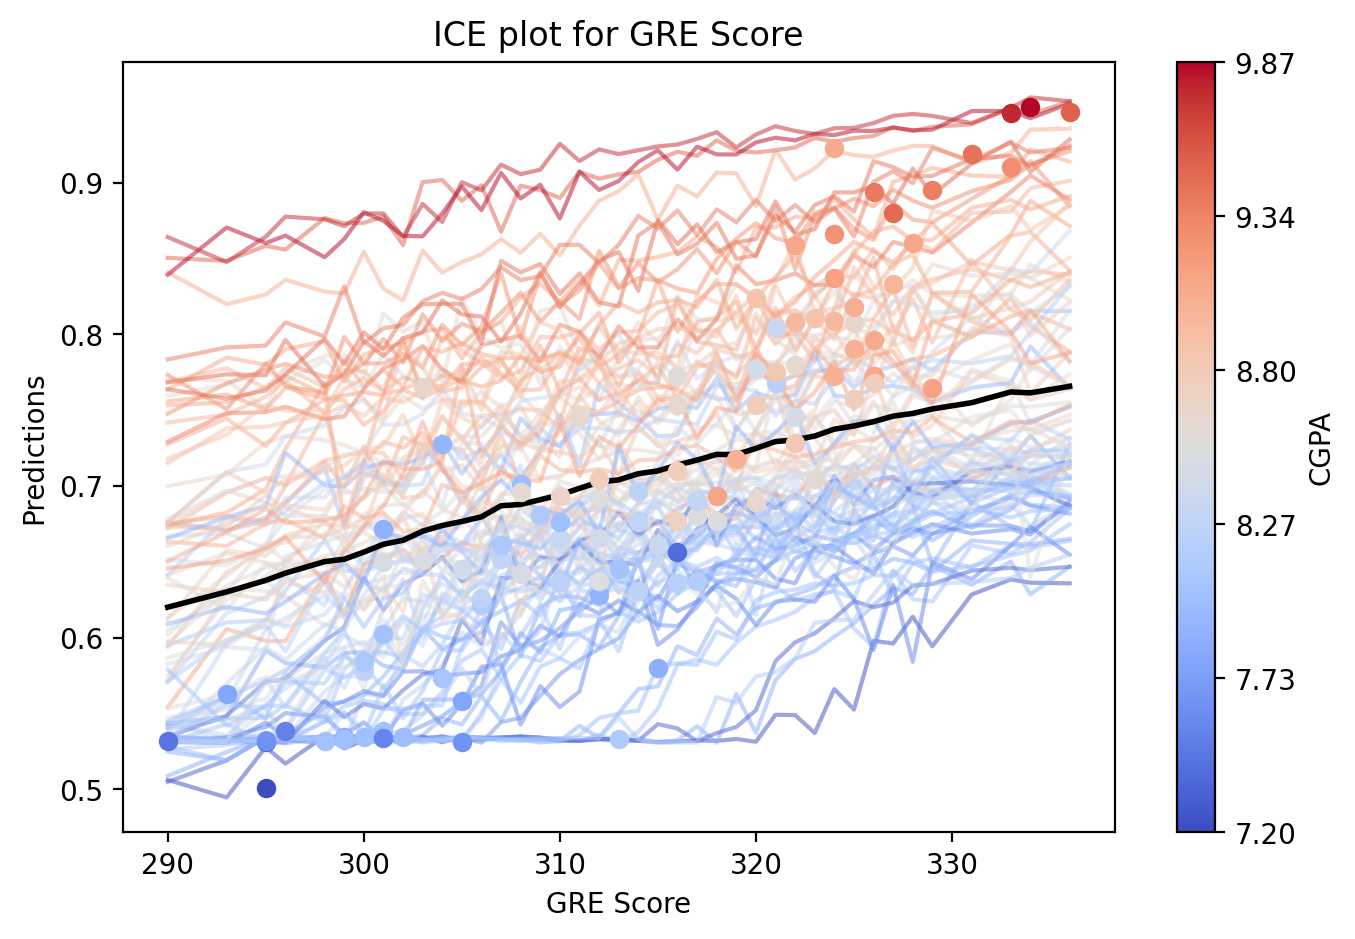

In [18]:
ice_plot(model, X_test_scaled, X_test, y_test,0, 'GRE Score')

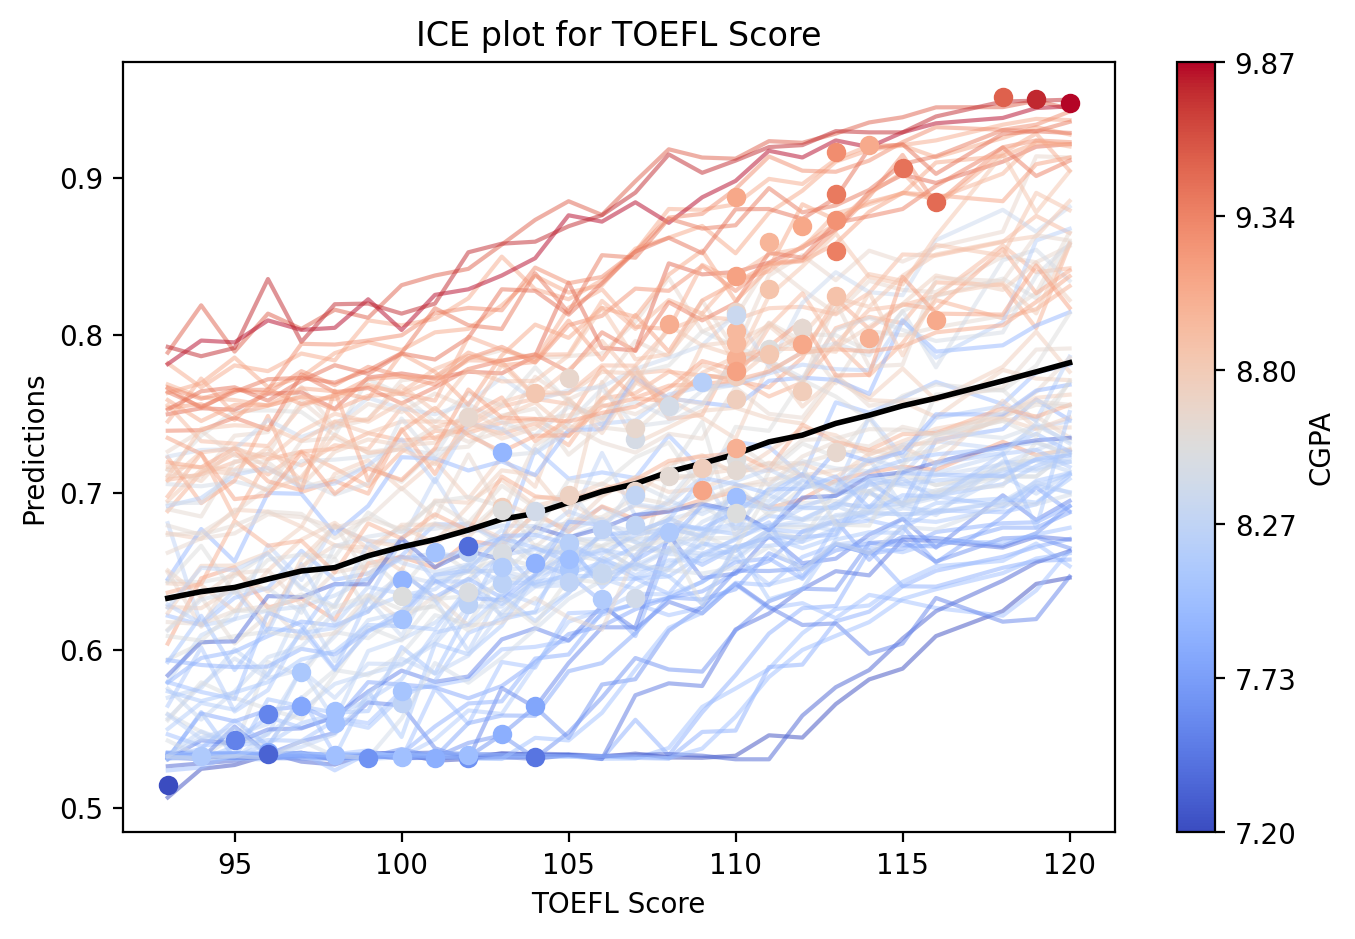

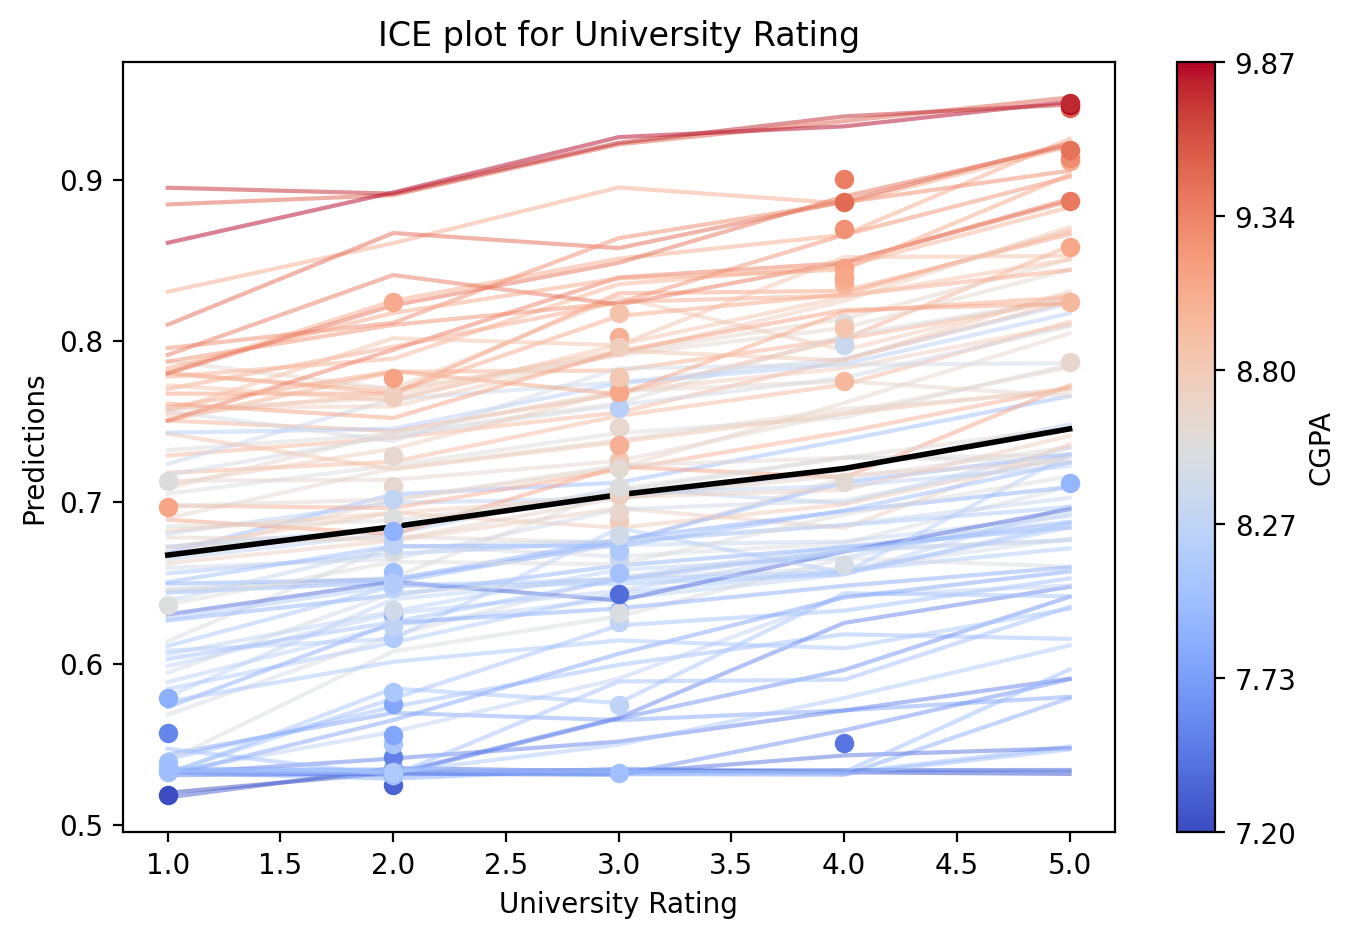

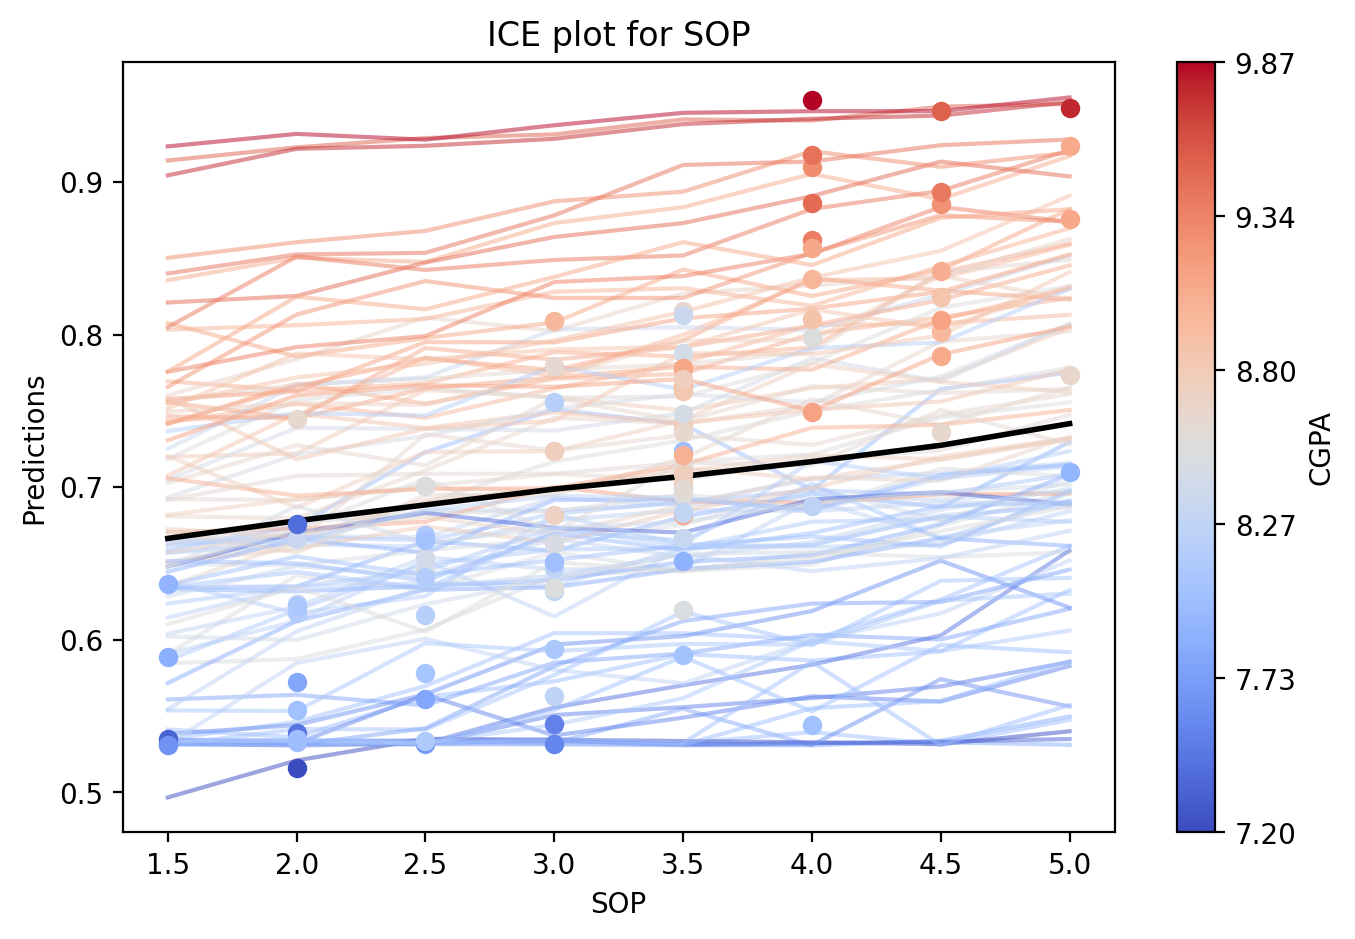

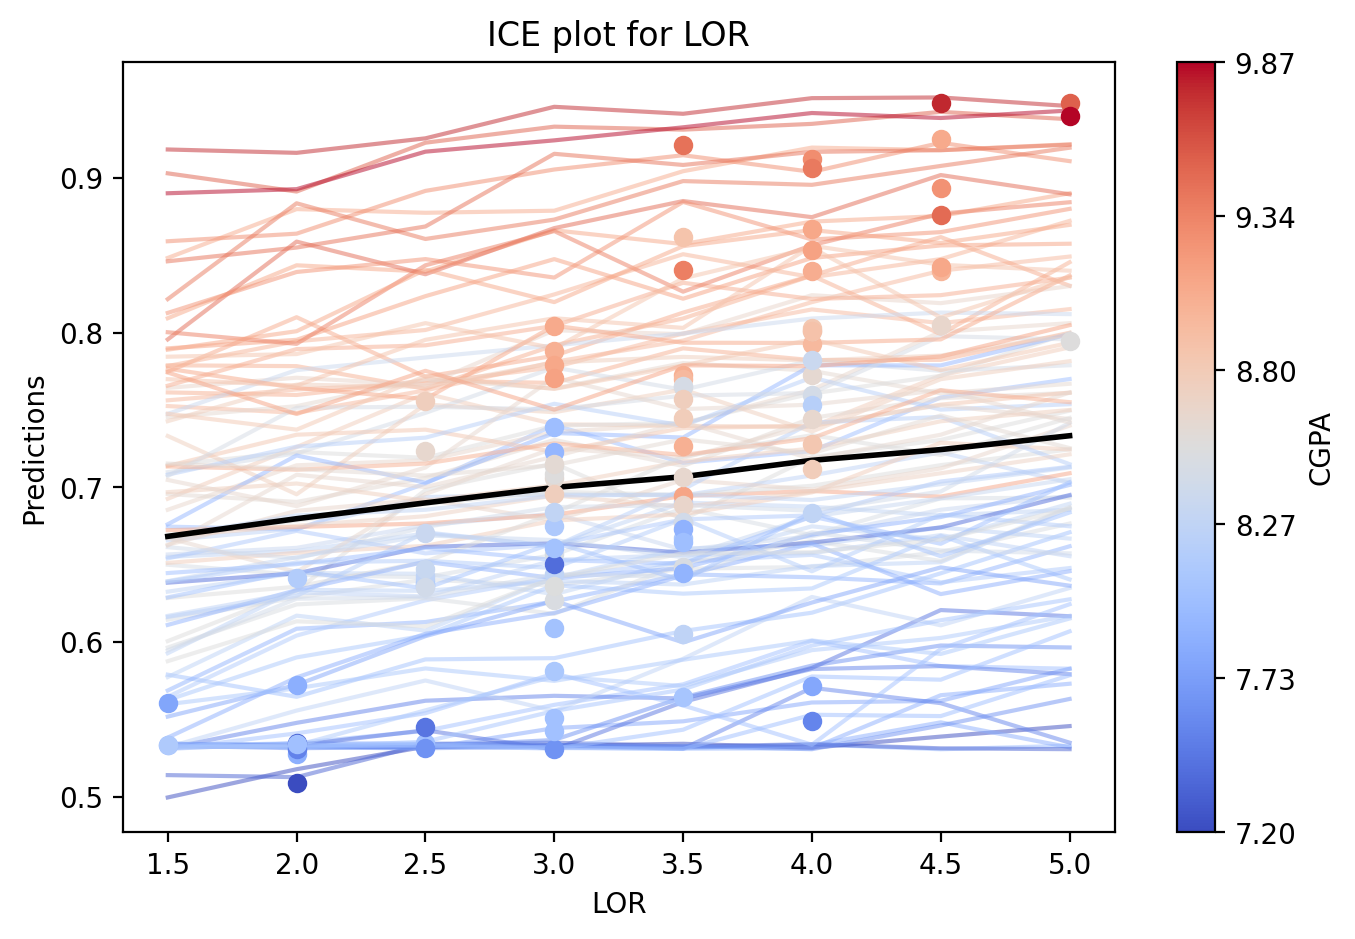

In [19]:
ice_plot(model, X_test_scaled, X_test, y_test,1,'TOEFL Score')
ice_plot(model, X_test_scaled, X_test, y_test,2, 'University Rating')
ice_plot(model, X_test_scaled, X_test, y_test,3, 'SOP')
ice_plot(model, X_test_scaled, X_test, y_test,4, 'LOR')

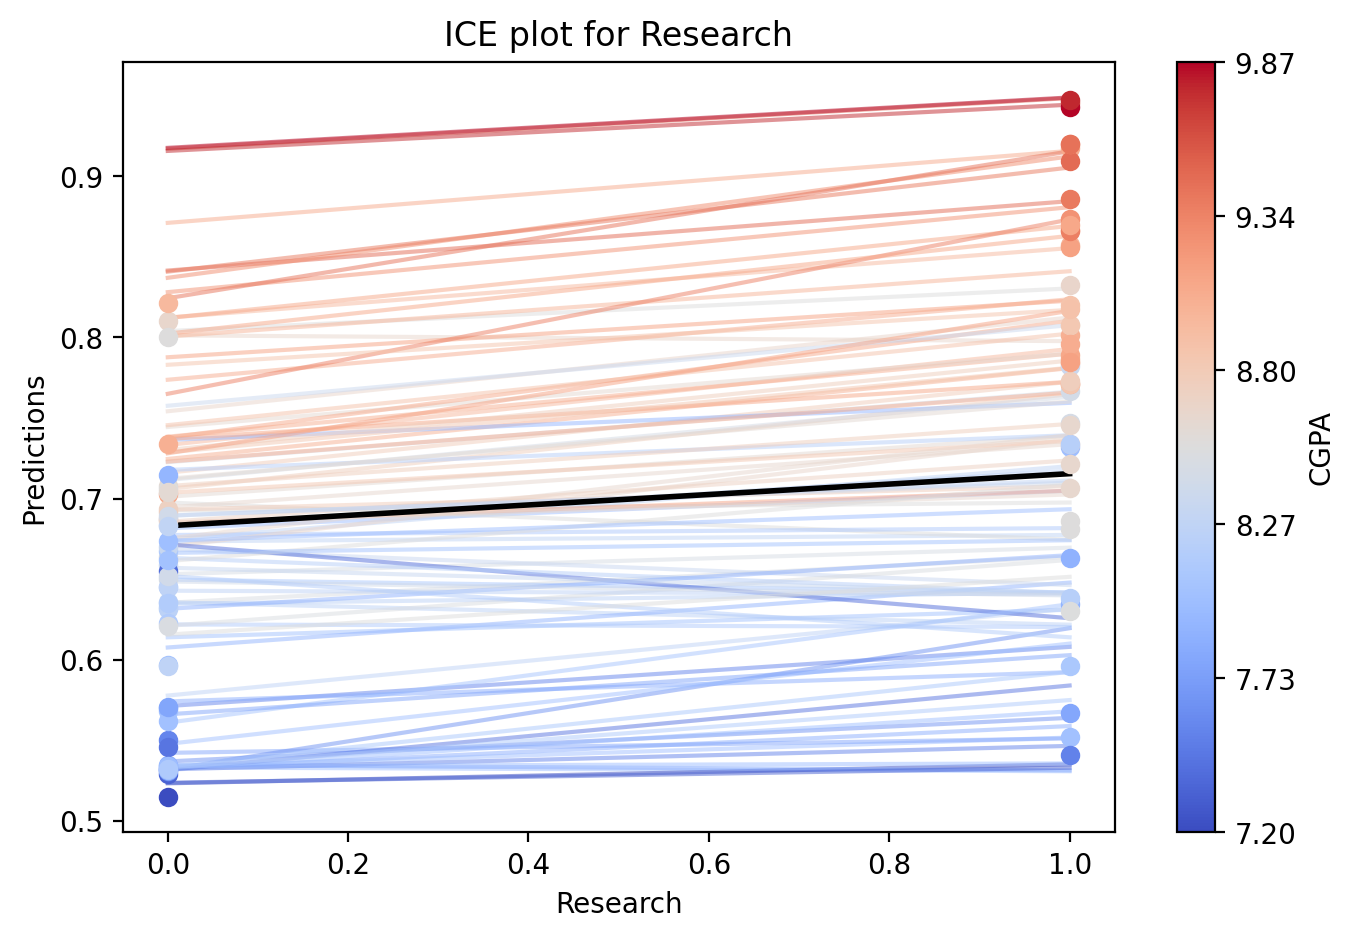

In [20]:
ice_plot(model, X_test_scaled, X_test, y_test, 5, 'Research',off=1)

In [21]:
class masked_model():
    def __init__(self, model):
        self.model = model
    
    def forward(self,x):
        _,_,_,_,_,prediction=model(x)
        return prediction

In [22]:
mod=masked_model(model)

In [30]:
num_runs=100

In [31]:
y_test_series = y_test.iloc[:, 0]
X_test_scaled[y_test_series.argmin()]
worst_instance = torch.tensor(X_test_scaled[y_test_series.argmin()]).unsqueeze(0).float().to(device)
best_instance = torch.tensor(X_test_scaled[y_test_series.argmax()]).unsqueeze(0).float().to(device)
#median_instance = torch.tensor(X_test_scaled[median_index]).unsqueeze(0).float().to(device)

baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)
avg_worst=0
avg_best=0
avg_base=0
for _ in range(num_runs):
    avg_worst+=mod.forward(worst_instance)
    avg_best+=mod.forward(best_instance)
    avg_base+=mod.forward(baseline)
avg_worst=avg_worst/num_runs
avg_best=avg_best/num_runs
avg_base=avg_base/num_runs
print(avg_worst)
print(avg_best)
print(avg_base)

tensor([[0.5474]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.9462]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.7059]], device='cuda:0', grad_fn=<DivBackward0>)


In [25]:
from captum.attr import KernelShap

# Instantiate KernelShap
shap = KernelShap(mod.forward)
# Compute Shapley values
worst_shap_values = shap.attribute(worst_instance, baseline)
best_shap_values = shap.attribute(best_instance, baseline)
baseline_shap_values=shap.attribute(baseline, baseline)

In [26]:
import shap
import numpy as np
def shap_vis(values,baseline_shap_values,data,feature_names):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=feature_names)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

[0.0373464  0.08568    0.05623903 0.01940314 0.02721286 0.02125998]
0.7216
[334. 120.   5.   4.   5.   1.]


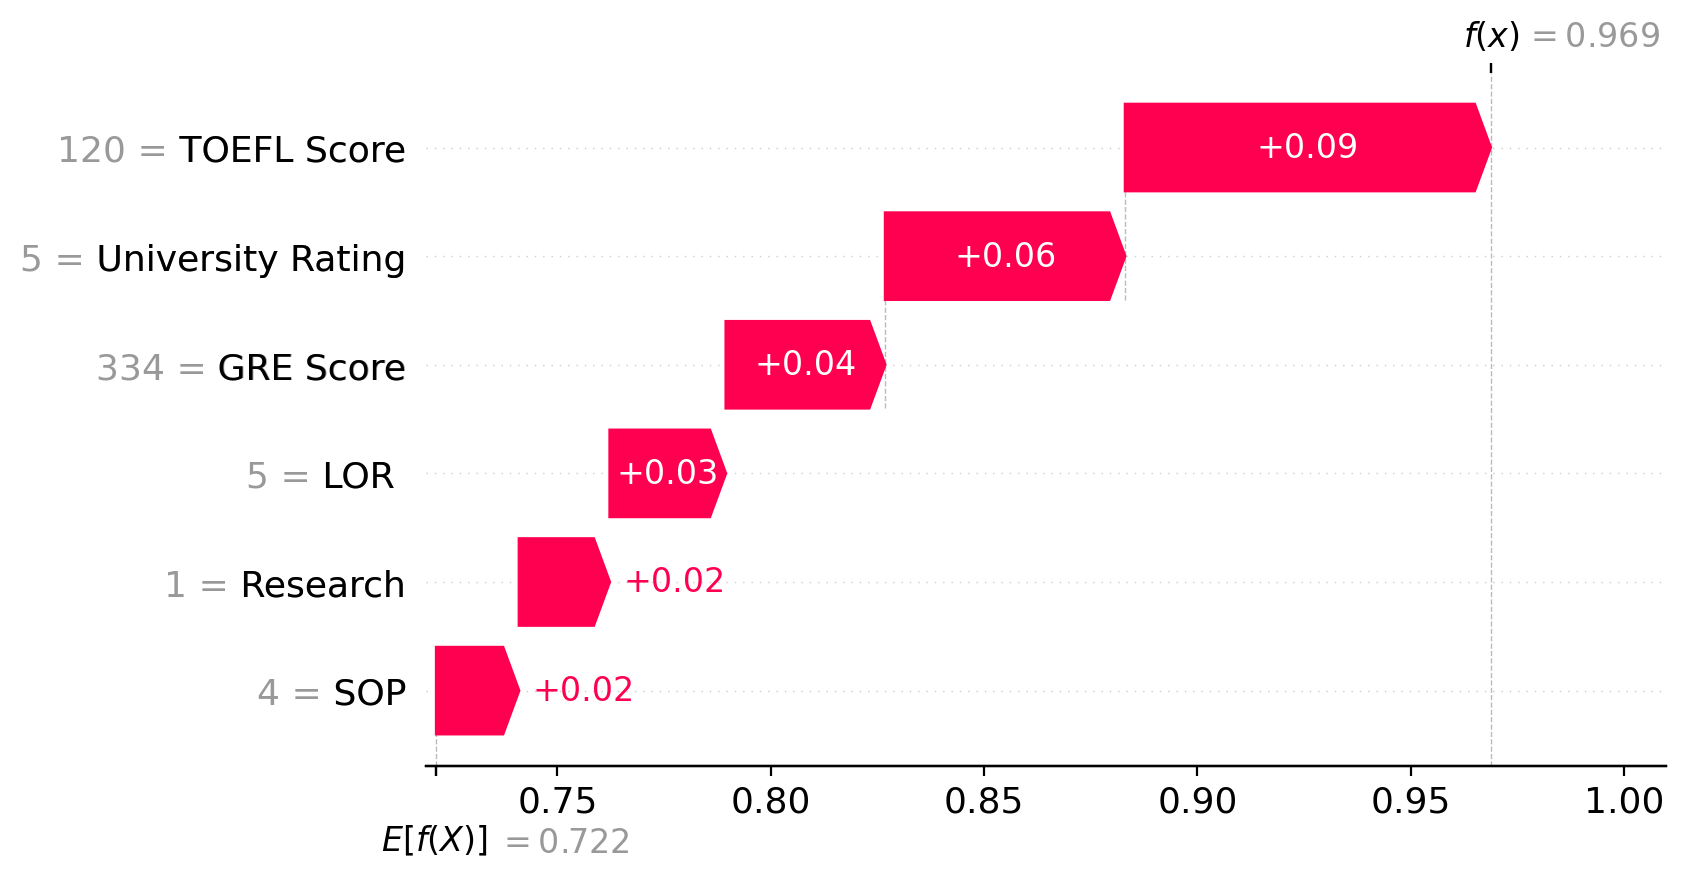

In [27]:
shap_vis(best_shap_values[0].cpu().detach().numpy(),0.7216,scaler.inverse_transform(best_instance.cpu().detach().numpy())[0],X_test_with_confounder.columns)

[-0.06199113 -0.05623763 -0.02279761  0.0132985  -0.00710284 -0.00298879]
0.7216
[2.98000e+02 9.80000e+01 2.00000e+00 4.00000e+00 3.00000e+00 1.66893e-08]


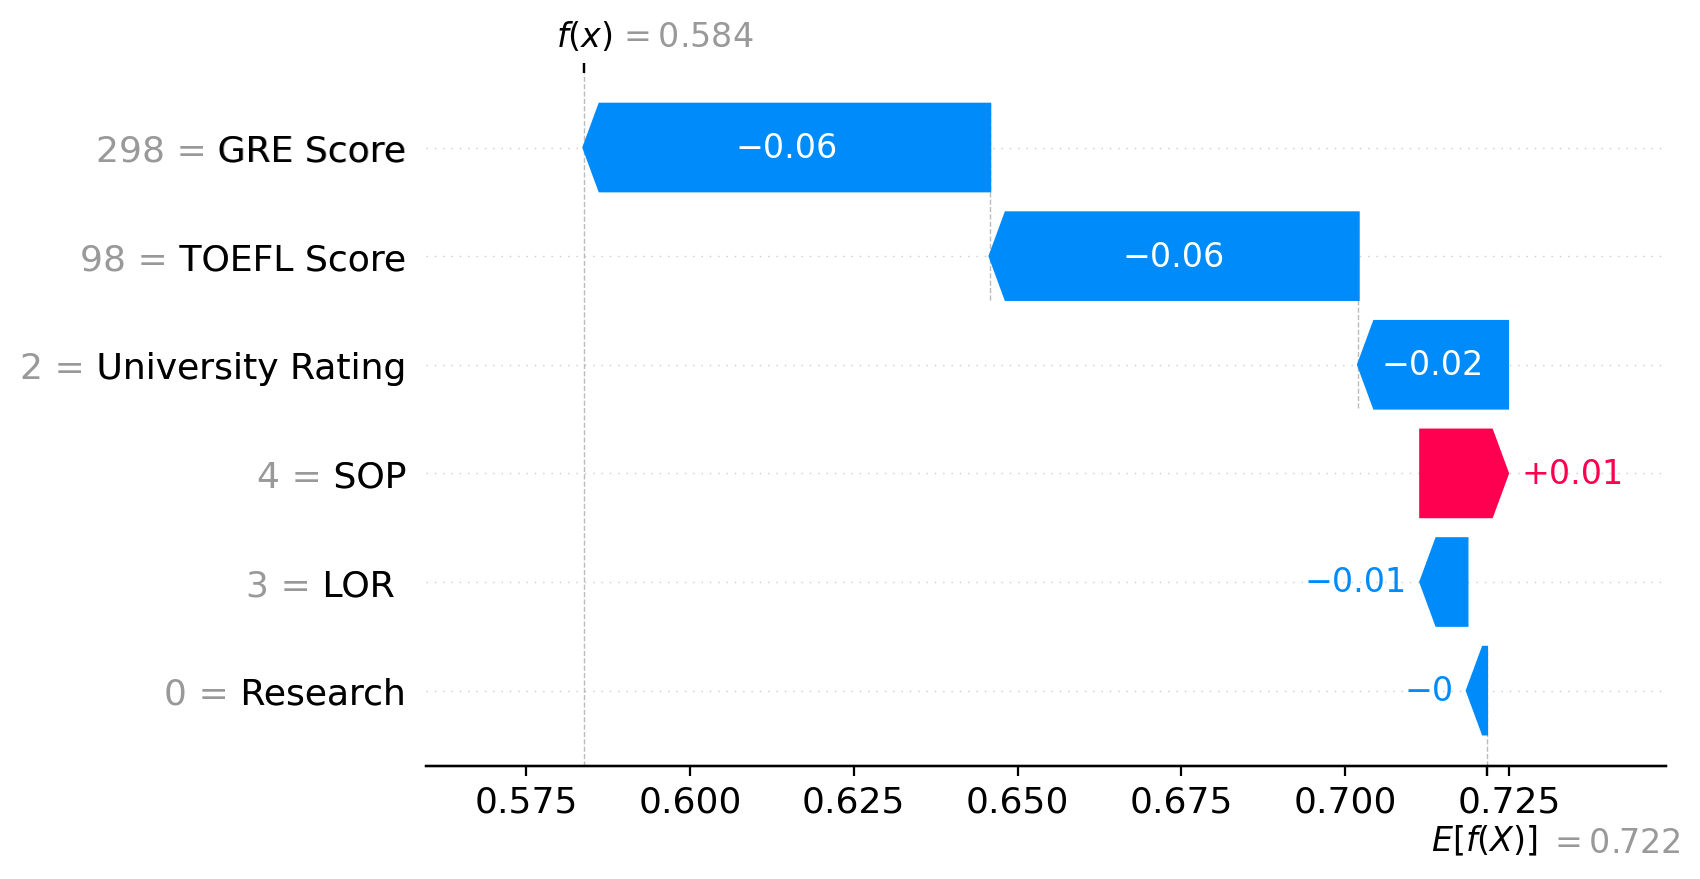

In [28]:
shap_vis(worst_shap_values[0].cpu().detach().numpy(),0.7216,scaler.inverse_transform(worst_instance.cpu().detach().numpy())[0],X_test_with_confounder.columns)

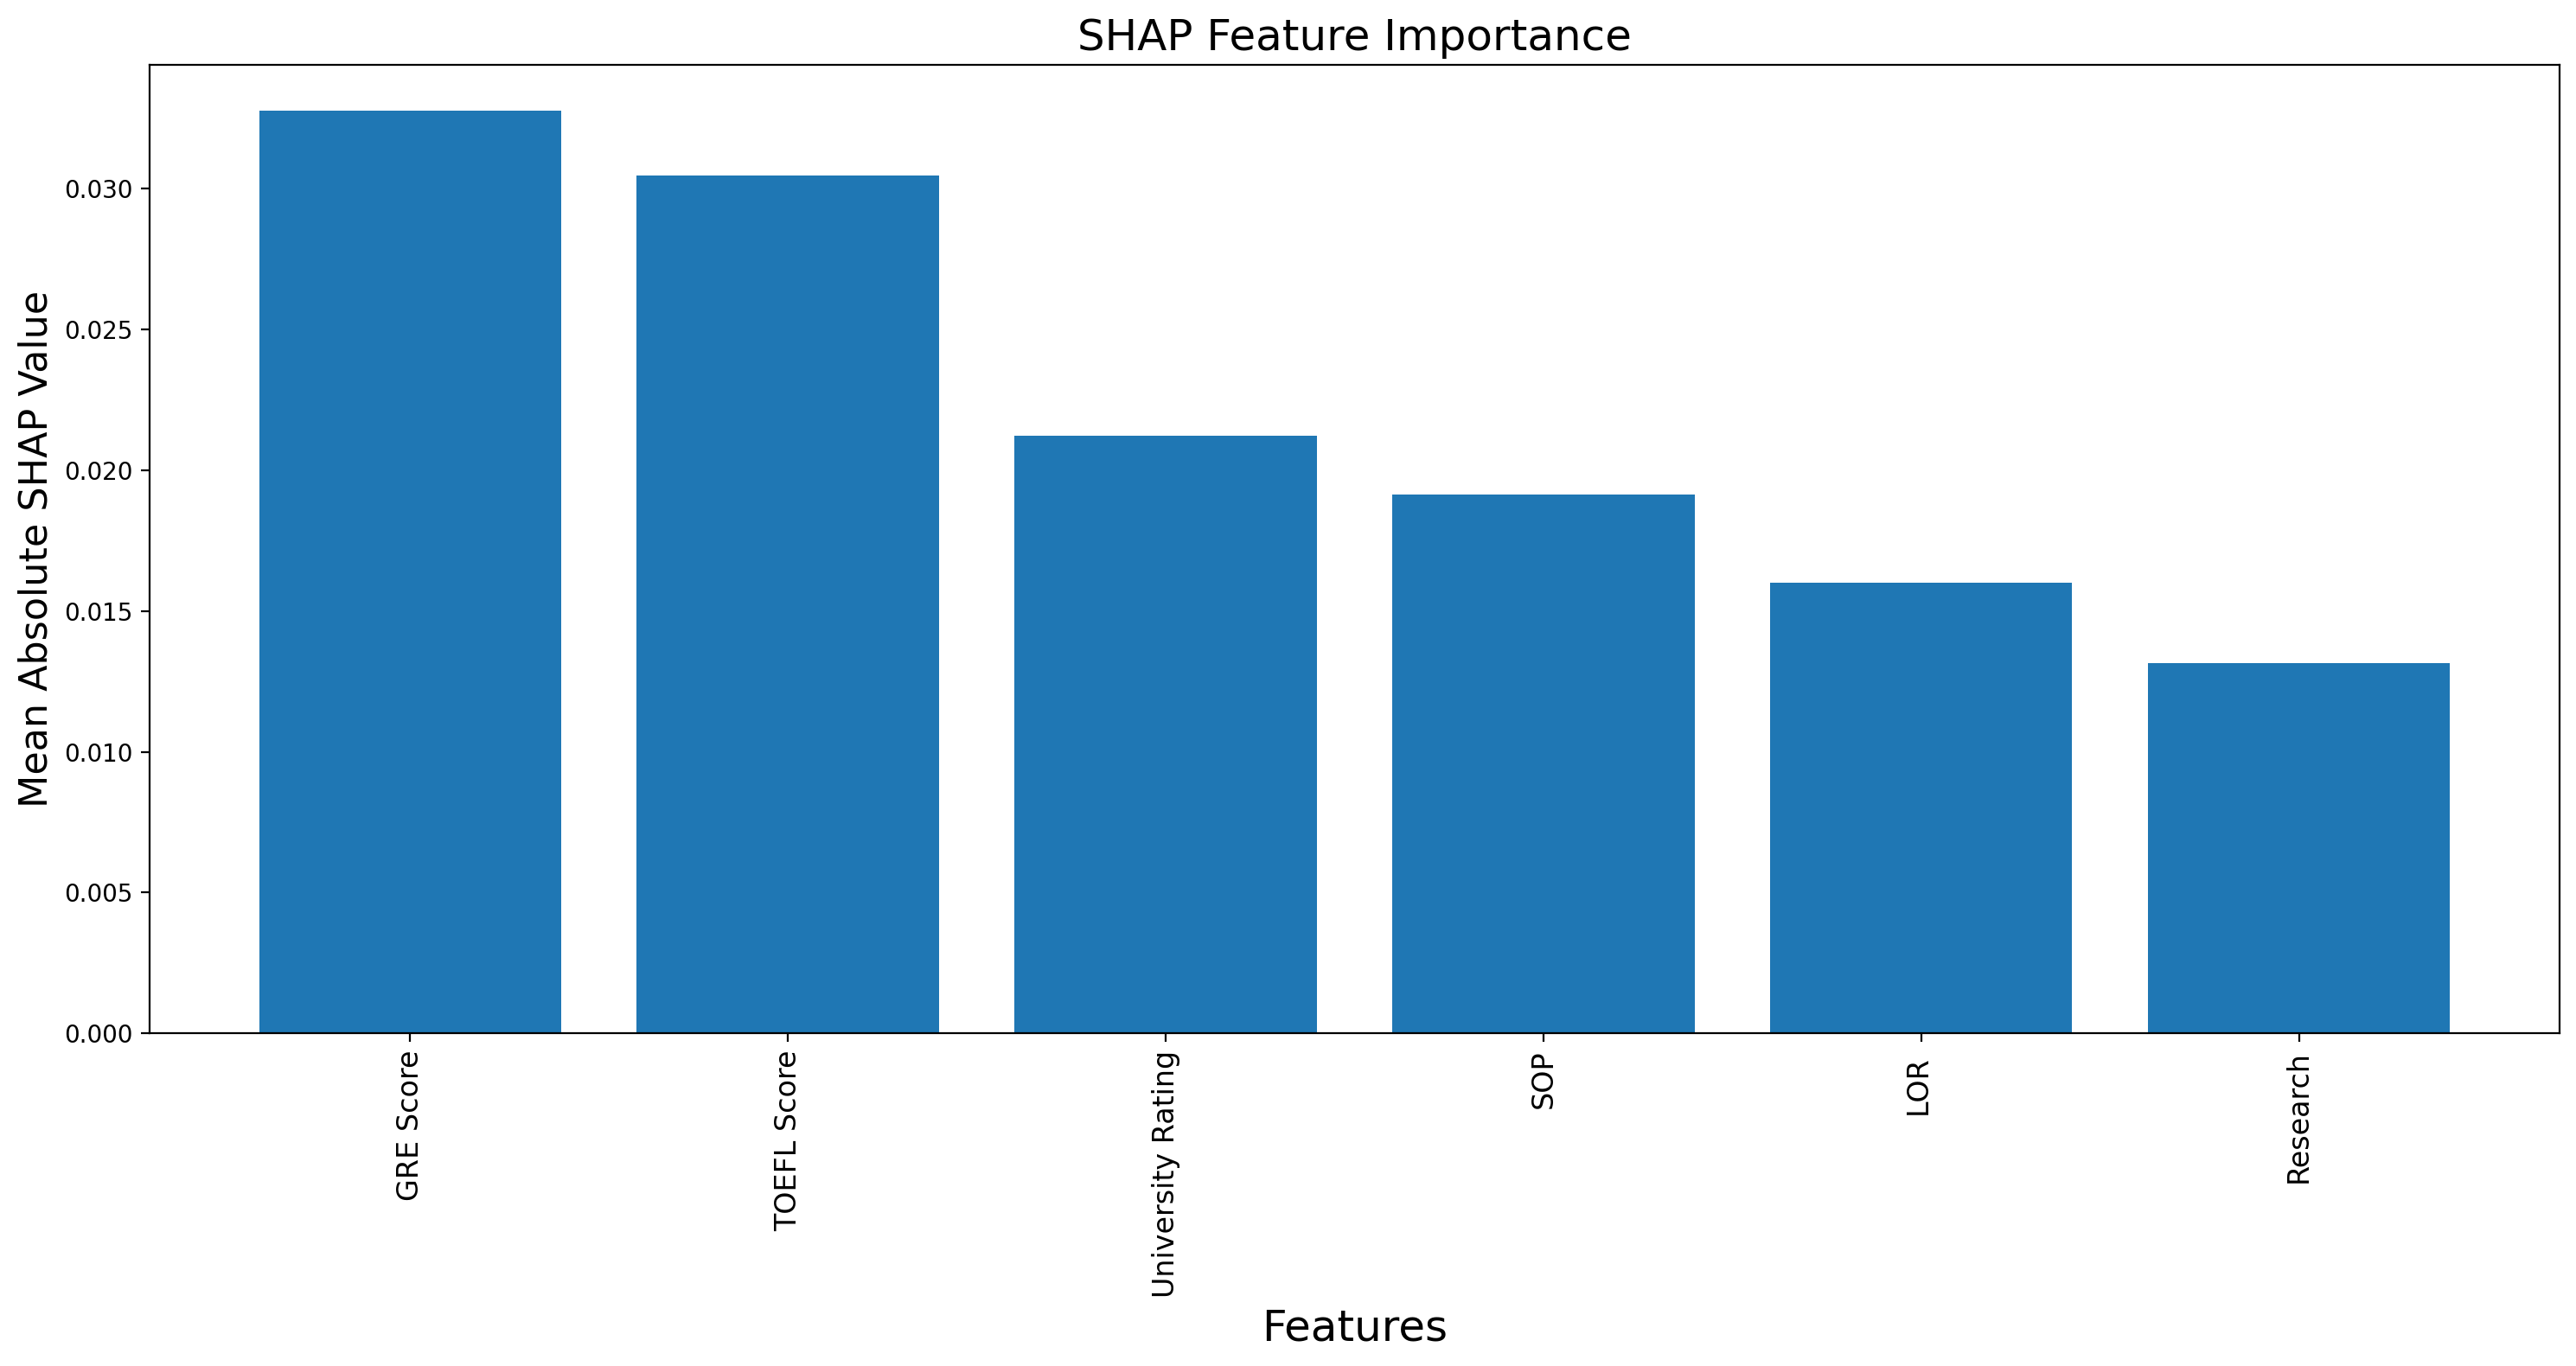

In [32]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
sk = KernelShap(mod.forward)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled)  
# Attribute SHAP values
global_shap_values = []

r_g=5
for instance in X_test_t:
    global_cumulative_shap_values = 0
    for _ in range(r_g):
        shap_values = sk.attribute(instance.unsqueeze(0).float().to(device), baseline,n_samples=200)
        global_cumulative_shap_values+=shap_values
    global_mean_shap_values=global_cumulative_shap_values/r_g
    global_shap_values.append(global_mean_shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_with_confounder.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


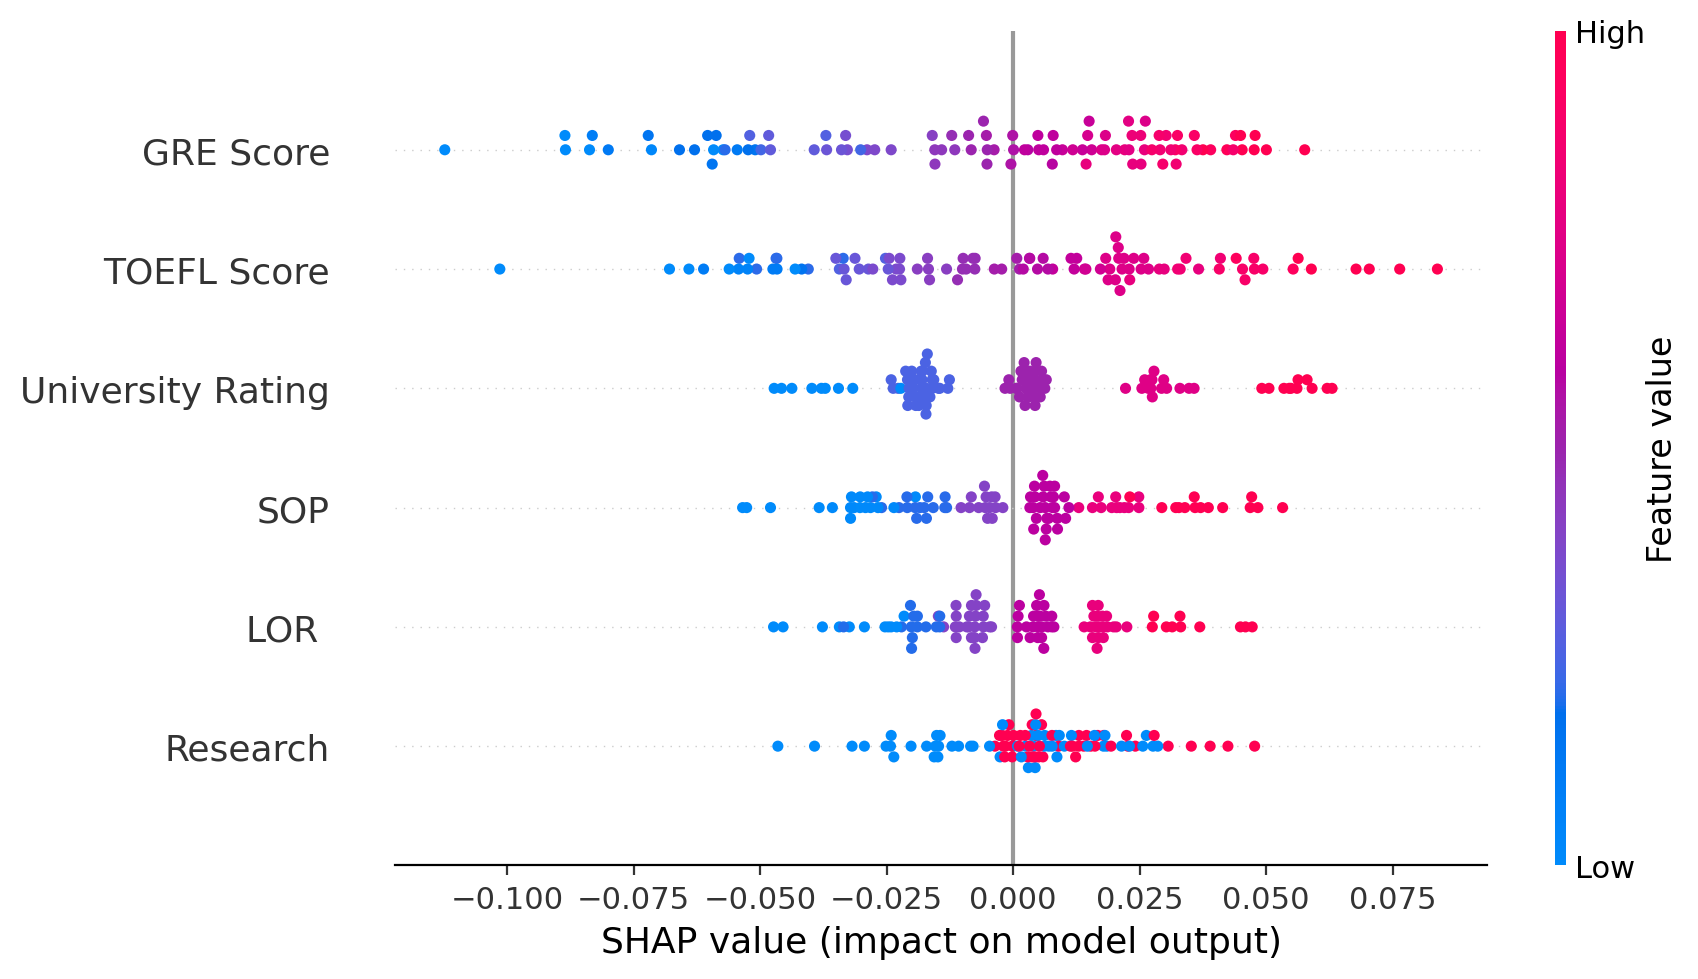

In [33]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled, feature_names=X_test_with_confounder.columns,plot_size=(9,5))
